# Stock Prices Predictions with Machine Learning

This Notebook will contain all the data engineering, the data analysis and the modeling phases needed to predict stock prices using a deep learning model.
The stocks analyzed will be the following:
* IBM
* AAPL (Apple Inc.)
* GOOGL (Alphabet Inc.)
* AMZN (Amazon Inc.)
The model will be


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import quandl
import datetime
import pandas_datareader.data as web
import pyflux

## Data gathering

Gatering data from two sources Alpha Vantage API

Target symbols declaration

In [2]:
ibm = 'IBM' 
aapl = 'AAPL'
googl = 'GOOGL'
amzn = 'AMZN'

### Gatering data from Alpha Vantage API

Setting dataset record start date and end date:
* start date will be the beginning of records in the AlphaVantage dataset
* end time will be today date

In [4]:
start = datetime.datetime(1999, 11, 1)
end = datetime.date.today()

Retrieving symbols data from AlphaVantage DB

In [5]:
df_av_ibm = web.DataReader(ibm, "av-daily-adjusted", start=start, end=end, api_key="os.getenv('ALPHAVANTAGE_API_KEY')")

In [6]:
df_av_aapl = web.DataReader(aapl, "av-daily-adjusted", start=start, end=end, api_key="os.getenv('ALPHAVANTAGE_API_KEY')")

In [7]:
df_av_googl = web.DataReader(googl, "av-daily-adjusted", start=start, end=end, api_key="os.getenv('ALPHAVANTAGE_API_KEY')")

In [8]:
df_av_amzn = web.DataReader(amzn, "av-daily-adjusted", start=start, end=end, api_key="os.getenv('ALPHAVANTAGE_API_KEY')")

In [9]:
df_av_ibm_ac = df_av_ibm['adjusted close']

In [10]:
df_av_aapl_ac = df_av_aapl['adjusted close']

In [11]:
df_av_googl_ac = df_av_googl['adjusted close']

In [12]:
df_av_amzn_ac = df_av_amzn['adjusted close']

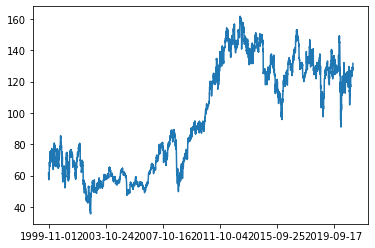

In [13]:
df_av_ibm_ac.plot()

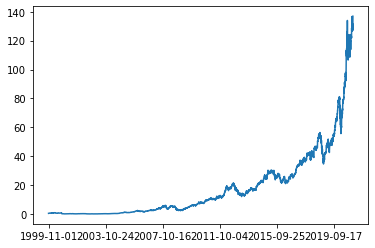

In [14]:
df_av_aapl_ac.plot()

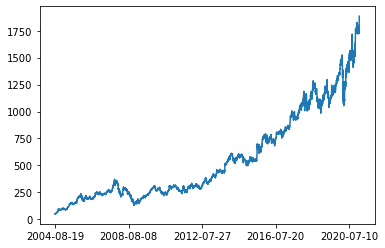

In [15]:
df_av_googl_ac.plot()

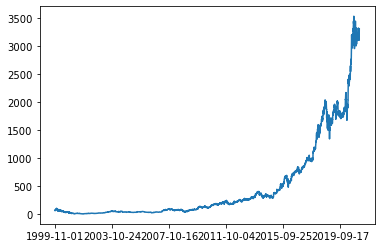

In [16]:
df_av_amzn_ac.plot()